In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join(os.path.pardir, 'src')))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}
import tensorflow as tf
import absl.logging

absl.logging.set_verbosity(absl.logging.ERROR)

from policy import ResNet, ConvNet

# Set memory growth
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from jem import JointEmbeddingModel, data_utils

use_saved_dataset = True

lr = 0.001
epochs = 10
batch_size = 128
input_state_embed = 64
hidden_state_embed = 32
output_state_embed = 16 
exp_embed = 32
output_exp_embed = 16

model_name = "net"
session_name = "falcon"
board_size = 7
board_name = f'{board_size}x{board_size}'
resnet = True

model_type = "resnet" if resnet else "convnet"

agents_to_sample = [0, 10, 20, 60, 100, 500]
cases_to_sample = 50

full_model_path = f"../models/saved_sessions/{model_type}/board_size_{board_size}/{session_name}/"

def load_model(full_name, model_name, epoch):
    model_path = full_name + model_name + "_" + str(epoch) + ".keras"
    if resnet:
        model = ResNet(board_size, model_path)
    else:
        model = ConvNet(board_size, model_path)
    return model

# Load the data
if use_saved_dataset:
    states, explanations, labels, max_sent_len, vocab = data_utils.load_datasets_from_pickle(board_size)
else:
    agents = [load_model(full_model_path, model_name, epoch) for epoch in agents_to_sample]
    states, explanations, labels, max_sent_len, vocab = data_utils.generate_data(agents, cases_to_sample, board_size)

    # Save the data
    data_utils.save_datasets_to_pickle(states, explanations, labels, max_sent_len, vocab, board_size)

vocab_size = len(vocab)

print("Total number of states:", states.shape[0], ",explanations:", explanations.shape[0], ",labels:", labels.shape[0], " with vocab size:", vocab_size, "and max sent len:", max_sent_len)

# Create a permutation
perm = np.random.permutation(states.shape[0])

# Apply the permutation to your arrays
states = states[perm]
explanations = explanations[perm]
labels = labels[perm]

# Split the data into 60% training, 20% validation, and 20% test
split1 = int(0.6 * states.shape[0])
split2 = int(0.8 * states.shape[0])

train_states = states[:split1]
train_explanations = explanations[:split1]
train_labels = labels[:split1]

val_states = states[split1:split2]
val_explanations = explanations[split1:split2]
val_labels = labels[split1:split2]

test_states = states[split2:]
test_explanations = explanations[split2:]
test_labels = labels[split2:]

# Print the shapes of the data
print("Train shapes:", train_states.shape, train_explanations.shape, train_labels.shape)
print("Val shapes:", val_states.shape, val_explanations.shape, val_labels.shape)
print("Test shapes:", test_states.shape, test_explanations.shape, test_labels.shape)

Loading dataset for board size 7
Total number of states: 1250 ,explanations: 1250 ,labels: 1250  with vocab size: 28 and max sent len: 10
Train shapes: (750, 5, 7, 7) (750, 10) (750,)
Val shapes: (250, 5, 7, 7) (250, 10) (250,)
Test shapes: (250, 5, 7, 7) (250, 10) (250,)


In [ ]:
# Print the first 10 cases
for i in range(30, 40):
    print("State:\n", train_states[i], "\nExplanation:", data_utils.convert_integers_to_explanations(train_explanations[i], vocab), "\nLabel:", train_labels[i])

### Train the joint embedding model

In [2]:
jem = JointEmbeddingModel(vocab_size=vocab_size, max_sent_len=max_sent_len, board_size=board_size, learning_rate=lr)

jem.fit(train_states, train_explanations, train_labels, val_states, val_explanations, val_labels, epochs=100, batch_size=batch_size)

jem.save_model('../models/jem/joint_embedding_model.keras')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 7, 7)]    0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 5, 7, 32)     2048        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 5, 7, 32)     9248        ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 5, 7, 32)     9248        ['conv2d_1[0][0]']               
                                                                                              

  0%|          | 0/100 [00:00<?, ?it/s]2024-03-04 16:05:45.083233: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2024-03-04 16:05:48.448308: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
Loss: 0.07049759477376938, Val Loss: 0.19858500361442566:  37%|███▋      | 37/100 [00:22<00:38,  1.66it/s]


KeyboardInterrupt: 

concept breakdown: {'null': 11, 'two_eyes': 10, 'one_eye': 9, 'capture_a_stone': 12, 'capture_group_of_stones': 17}
Skip count: 191
--- Test Results ---
Recall@1: 30.51%
Recall@2: 37.29%
Recall@3: 55.93%


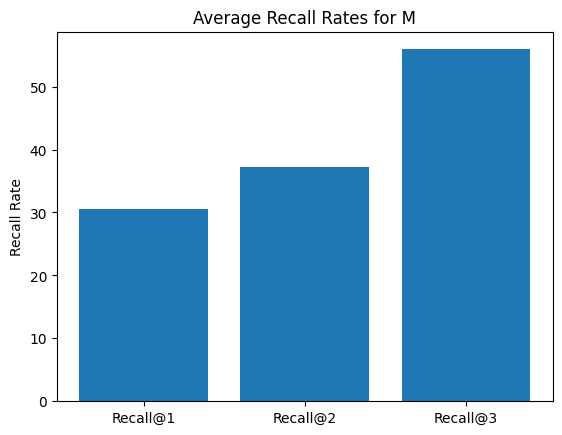

In [3]:
# Define necessary variables
explanation_list = data_utils.get_explanation_list()  # Get the list of explanations
confusion_matrix = data_utils.init_confusion_matrix()  # Initialize the confusion matrix
encoded_explanations = [data_utils.convert_explanation_to_integers(explanation, vocab, max_sent_len) for explanation in (explanation_list)]  # Convert explanations to integers

gt_dict = {data_utils.translate_explanation(explanation): 0 for explanation in explanation_list}  # Dictionary to store ground truth explanations

explanation_predictions = []  # List to store predicted explanations
predicted_explanation_embeddings = []  # List to store predicted explanation embeddings
predicted_state_embeddings = []  # List to store predicted state embeddings

recall_at_1 = 0  # Counter for recall at 1
recall_at_2 = 0  # Counter for recall at 2
recall_at_3 = 0  # Counter for recall at 3

count_ignore = 0  # Counter for ignored cases

# Get the embeddings
# The t-SNE visualizations are created using the models' training dataset.
for i in range(len(test_states)):
    if test_labels[i] == 1:
        # Skip the misaligned data cases
        count_ignore += 1
        continue

    l2_norm_arr = []  # List to store L2 norms

    total_state_embeddings = []  # List to store total state embeddings
    total_explanation_embeddings = []  # List to store total explanation embeddings

    for j, explanation in enumerate(explanation_list):
        get_j_encoded_explanation = data_utils.convert_explanation_to_integers(explanation, vocab, max_sent_len)

        state_embed, exp_embed = jem.predict(test_states[i], get_j_encoded_explanation)
        total_state_embeddings.append(state_embed)
        total_explanation_embeddings.append(exp_embed)

        # Calculate the L2 norm
        differences = state_embed - exp_embed
        l2_norm = np.linalg.norm(differences, axis=1, ord=2)
        l2_norm_arr.append(l2_norm)

    min_values = sorted(range(len(l2_norm_arr)), key=lambda sub: l2_norm_arr[sub])[:3]  # Get indices of minimum L2 norms
    predicted_index = np.argmin(np.array(l2_norm_arr))  # Get the index of the predicted explanation

    gt_key = data_utils.convert_integers_to_explanations(test_explanations[i], vocab)  # Get the ground truth explanation
    key_at_1 = data_utils.convert_integers_to_explanations(encoded_explanations[min_values[0]], vocab)  # Get the explanation at index 1
    key_at_2 = data_utils.convert_integers_to_explanations(encoded_explanations[min_values[1]], vocab)  # Get the explanation at index 2
    key_at_3 = data_utils.convert_integers_to_explanations(encoded_explanations[min_values[2]], vocab)  # Get the explanation at index 3

    gt_dict[gt_key] += 1  # Increment the count of the ground truth explanation
    confusion_matrix[gt_key][key_at_1] += 1  # Increment the count of the confusion matrix
    if gt_key == key_at_1:
        recall_at_1 += 1  # Increment the count of recall at 1
    if gt_key == key_at_1 or gt_key == key_at_2:
        recall_at_2 += 1  # Increment the count of recall at 2
    if gt_key == key_at_1 or gt_key == key_at_2 or gt_key == key_at_3:
        recall_at_3 += 1  # Increment the count of recall at 3
    
    explanation_predictions.append(data_utils.translate_explanation(explanation_list[predicted_index]))  # Append the predicted explanation
    predicted_explanation_embeddings.append(total_explanation_embeddings[predicted_index])  # Append the predicted explanation embedding
    predicted_state_embeddings.append(total_state_embeddings[predicted_index])  # Append the predicted state embedding

recall_at_1_percent = round((recall_at_1 / float(len(test_states) - count_ignore)) * 100, 2)  # Calculate recall at 1 percentage
recall_at_2_percent = round((recall_at_2 / float(len(test_states) - count_ignore)) * 100, 2)  # Calculate recall at 2 percentage
recall_at_3_percent = round((recall_at_3 / float(len(test_states) - count_ignore)) * 100, 2)  # Calculate recall at 3 percentage

print("concept breakdown: " + str(gt_dict))  # Print the concept breakdown
print("Skip count: " + str(count_ignore))  # Print the skip count
print("--- Test Results ---")
print(f"Recall@1: {recall_at_1_percent}%")  # Print recall at 1 percentage
print(f"Recall@2: {recall_at_2_percent}%")  # Print recall at 2 percentage
print(f"Recall@3: {recall_at_3_percent}%")  # Print recall at 3 percentage

# Plot the recall rates
fig, ax = plt.subplots()
ax.bar(['Recall@1', 'Recall@2', 'Recall@3'], [recall_at_1_percent, recall_at_2_percent, recall_at_3_percent])
ax.set_ylabel('Recall Rate')
ax.set_title('Average Recall Rates for M')
plt.show()

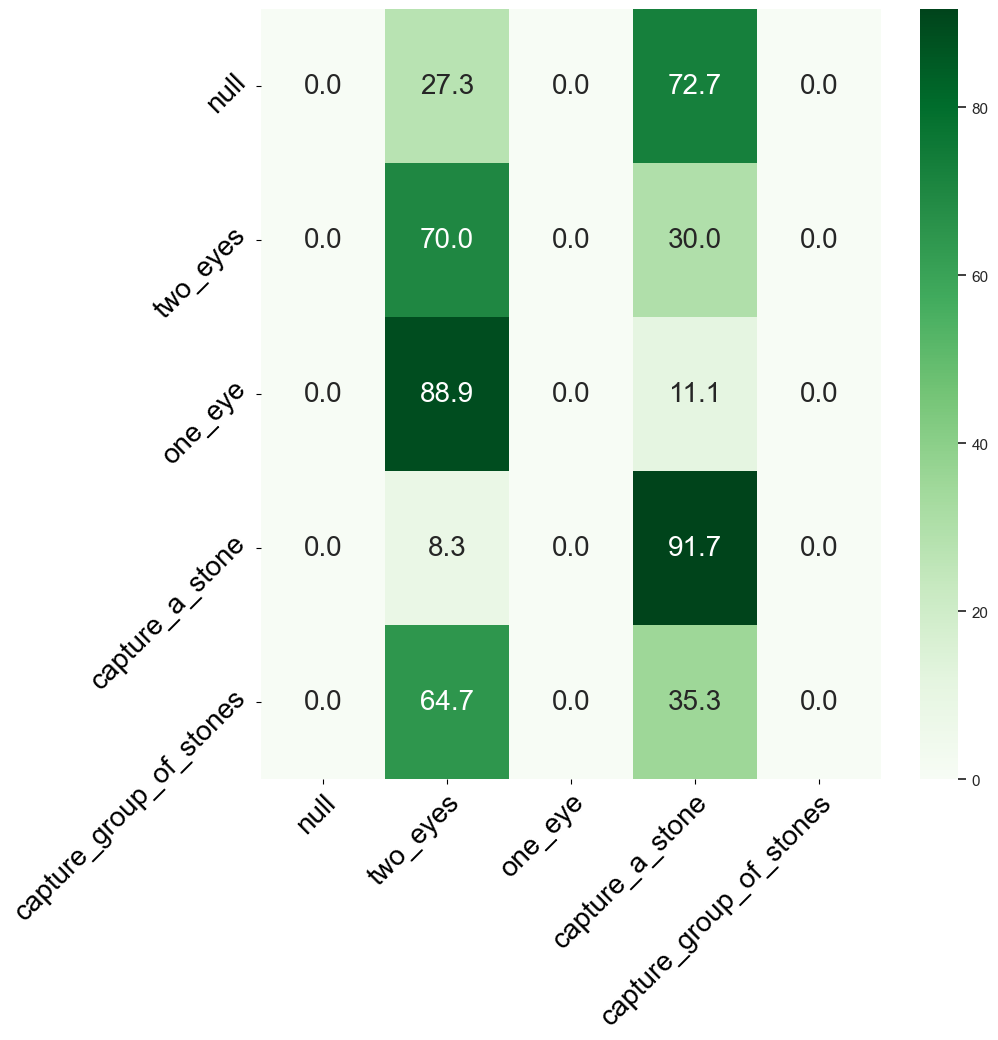

In [4]:
import pandas as pd
import seaborn as sne

keys_ = list(confusion_matrix.keys())
arr2 = []
for i in keys_:
    class_sum = float(sum(confusion_matrix[i].values()))
    class_arr = []
    for j in keys_:
        calc_ = confusion_matrix[i][j] / class_sum
        class_arr.append(calc_)
    arr2.append(class_arr)

labels = [data_utils.translate_explanation(explanation_list[i]) for i in range(len(explanation_list))]
df_cm2 = pd.DataFrame(np.array(arr2)*100, labels, labels)
fig, ax = plt.subplots(figsize=(10,10)) 
sne.set_theme(font_scale=1.0) # for label size
sne.heatmap(df_cm2, annot=True, annot_kws={"size": 20}, cmap="Greens", fmt='.1f') # font size
plt.xticks(rotation=45, fontsize=20, horizontalalignment="right", verticalalignment="top", rotation_mode="anchor")
plt.yticks(rotation=45, fontsize=20, horizontalalignment="right", verticalalignment="bottom", rotation_mode="anchor")
plt.show()

[t-SNE] Computing 58 nearest neighbors...
[t-SNE] Indexed 59 samples in 0.000s...
[t-SNE] Computed neighbors for 59 samples in 0.109s...
[t-SNE] Computed conditional probabilities for sample 59 / 59
[t-SNE] Mean sigma: 0.194693
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.554535
[t-SNE] KL divergence after 700 iterations: 0.129104


/var/folders/k4/t2xnyks517g9v60tdd71p4_00000gn/T/ipykernel_96928/2080038686.py:20: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sne.scatterplot(x=state_embed_tsne[:,0], y=state_embed_tsne[:,1], hue=explanation_predictions, legend='full', palette=palette)


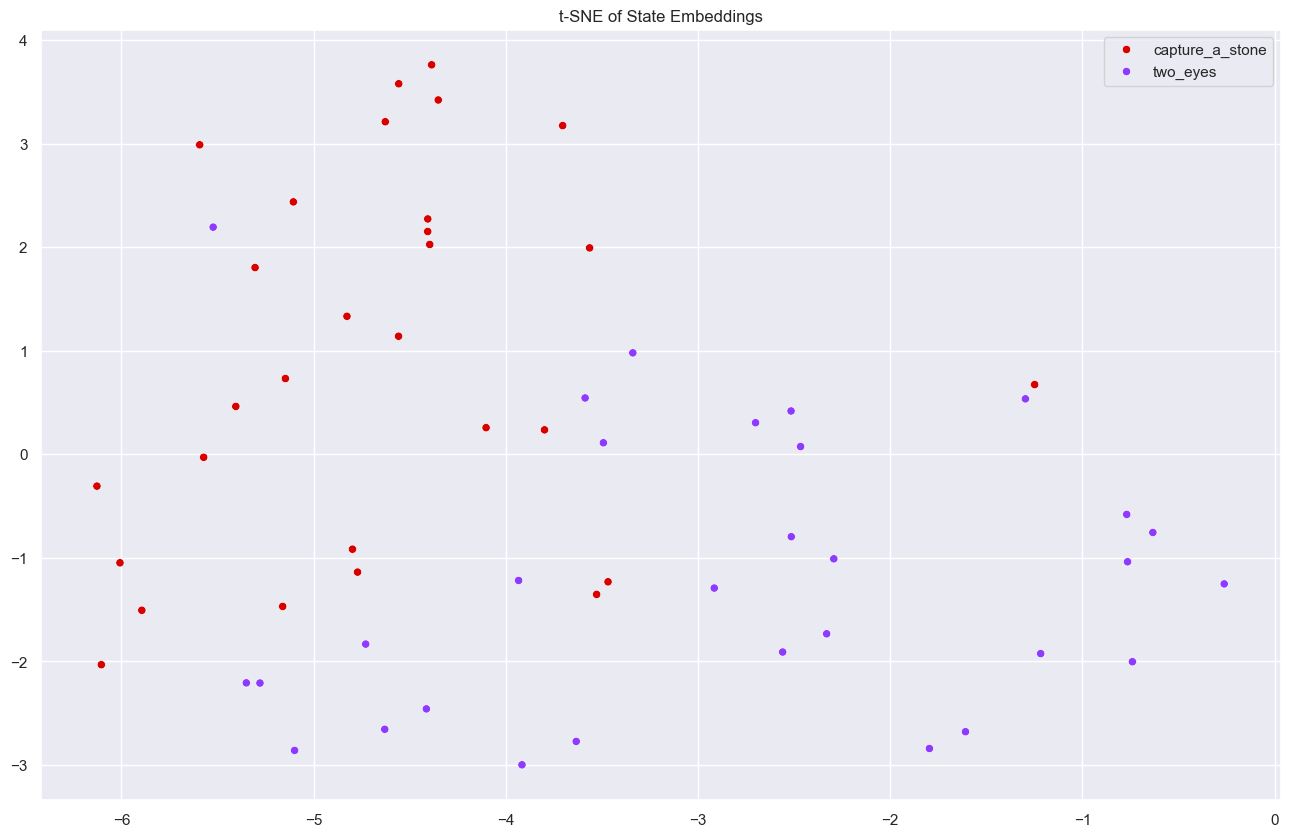

In [5]:
# Import necessary modules
from sklearn.manifold import TSNE  # For t-SNE visualization
import colorcet as cc  # For color palette

new_state_embed = []

for list_ in predicted_state_embeddings:
    new_state_embed.append(list_[0])

new_state_embed = np.array(new_state_embed)

# Fit the t-sne
tsne = TSNE(n_components=2, verbose=1)
state_embed_tsne = tsne.fit_transform(new_state_embed)


# Plot the t-sne
palette = sne.color_palette(cc.glasbey, 5)
plt.figure(figsize=(16,10))
sne.scatterplot(x=state_embed_tsne[:,0], y=state_embed_tsne[:,1], hue=explanation_predictions, legend='full', palette=palette)
plt.title('t-SNE of State Embeddings')
plt.plot()
plt.show()